# RNetwork Training

In [58]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [59]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
import envs.walker_utils as walker_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config Utils

In [61]:
cfg_path = f"../conf/config.yaml"

env_name = 'walker'

cfg = OmegaConf.load(cfg_path)
cfg.exploration_buffer.data_dir = "/checkpoint/linamezghani/offline-gcrl/data/walker/proto/buffer"
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

In [62]:
env = envs.make_env(cfg.env, space_info)

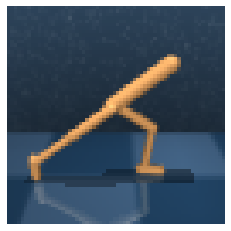

In [63]:
obs = walker_utils.get_state_from_lexa(env, env.goals['state'][4])
plt.imshow(env.get_image_from_obs(obs).transpose((1, 2, 0)))
plt.axis('off')
plt.show()

## RNet dataset

In [68]:
print(cfg.rnet.dataset)

{'thresh': 10, 'neg_thresh': 0, 'in_traj_ratio': 0.5, 'symmetric': True, 'valid_ratio': 0.05, 'num_pairs': {'train': 500000, 'val': 100000}}


In [88]:
cfg.rnet.dataset.thresh = 2
cfg.rnet.dataset.symmetric = False

expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

loading exploration buffer


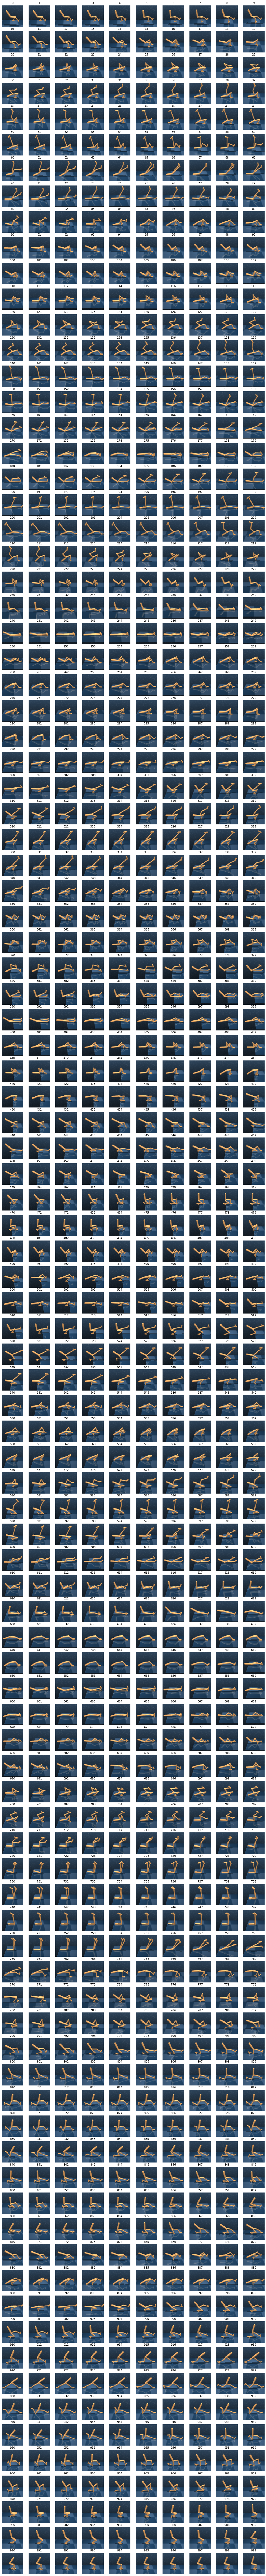

In [70]:
n = 1000
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    state = expl_buffer.states[300][i]
    obs = walker_utils.get_state_from_lexa(env, state[:9])
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

## Train RNet

In [89]:
cfg.rnet.model.remove_velocity = True

model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [90]:
cfg.rnet.train.num_epochs = 10

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.27,  acc 0.92 - val loss 0.13,  acc 0.96
rnet epoch 1 - train loss 0.11,  acc 0.97 - val loss 0.07,  acc 0.98
rnet epoch 2 - train loss 0.06,  acc 0.98 - val loss 0.05,  acc 0.98
rnet epoch 3 - train loss 0.06,  acc 0.98 - val loss 0.05,  acc 0.99
rnet epoch 4 - train loss 0.05,  acc 0.98 - val loss 0.05,  acc 0.98
rnet epoch 5 - train loss 0.05,  acc 0.98 - val loss 0.05,  acc 0.99
rnet epoch 6 - train loss 0.05,  acc 0.98 - val loss 0.04,  acc 0.99
rnet epoch 7 - train loss 0.05,  acc 0.98 - val loss 0.04,  acc 0.99
rnet epoch 8 - train loss 0.05,  acc 0.98 - val loss 0.04,  acc 0.99
rnet epoch 9 - train loss 0.05,  acc 0.98 - val loss 0.04,  acc 0.99


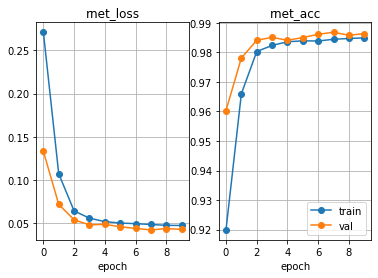

In [91]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

In [92]:
model.to(device)
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
model.eval()
model.to("cpu")
fig = env.plot_embeddings(model, points['state'][:, :], points['state'][:, :],
                          show_colors=True)

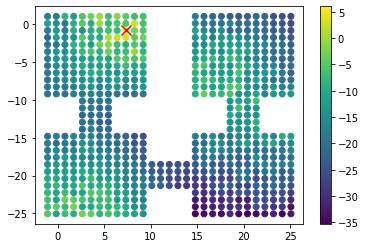

In [9]:
i = np.random.randint(0, points['state'][:, :3].shape[0])
fig = env.plot_values(model, points['state'][:, :3][i], points['state'][:, :3][i], points['state'][:, :3],
                      points['state'][:, :3])

## Build Memory

In [93]:
cfg.rnet.memory.skip = 1
cfg.rnet.memory.skip_traj = 0.01
cfg.rnet.memory.capacity = 1000
cfg.rnet.memory.directed = True

In [ ]:
memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

model = model.to(device)
memory = build_memory(cfg.rnet.memory, space_info, model, expl_buffer, device)
memory.compute_dist()

Updating Memory:  95%|█████████▍| 9483/10000 [01:42<00:14, 35.03it/s] 

In [ ]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx[i]]
        print(idx[i])
        obs = walker_utils.get_state_from_lexa(env, state_NN[:9]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out[idx[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()

In [ ]:
memory.compute_dist()
print(len(memory))

In [ ]:
(memory.adj_matrix == memory.adj_matrix.T).all()

In [ ]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    state = memory.states[i]
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

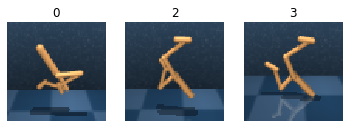

In [85]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n
    num_rows = 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
    for p in range(n):
        state = memory.states[path[p]]
        obs = walker_utils.get_state_from_lexa(env, state[:9]) 
        img = env.get_image_from_obs(obs)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p]))
    plt.show()
    
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
show_path(env, memory, i, j)

In [320]:
np.max(memory.dist)

9.0

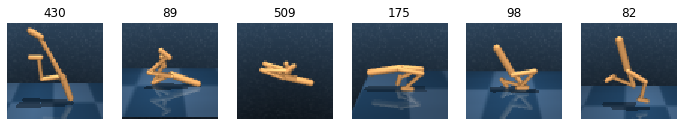

In [339]:
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
show_path(env, memory, i, j)

tensor(520, device='cuda:1')
tensor(277, device='cuda:1')
tensor(166, device='cuda:1')
tensor(410, device='cuda:1')
tensor(167, device='cuda:1')


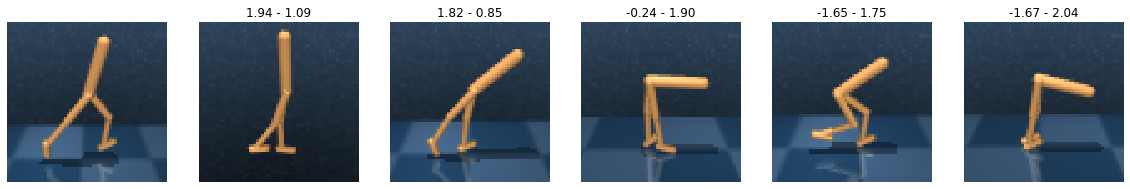

In [334]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx[i]]
        print(idx[i])
        obs = walker_utils.get_state_from_lexa(env, state_NN[:9]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out[idx[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()

obs, i, j = expl_buffer.get_random_obs()

#i, j = 6486, 513
#i, j = 7080, 198
#obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

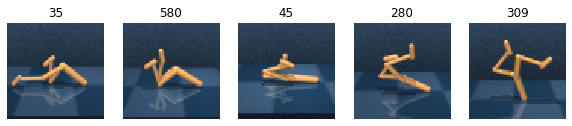

In [362]:
_, i1, j1 = expl_buffer.get_random_obs()
show_path(env, memory, NN[i1, j1], 309)

tensor(556, device='cuda:1')
tensor(612, device='cuda:1')
tensor(613, device='cuda:1')
tensor(609, device='cuda:1')
tensor(555, device='cuda:1')
tensor(456, device='cuda:1')
tensor(387, device='cuda:1')
tensor(309, device='cuda:1')
tensor(536, device='cuda:1')


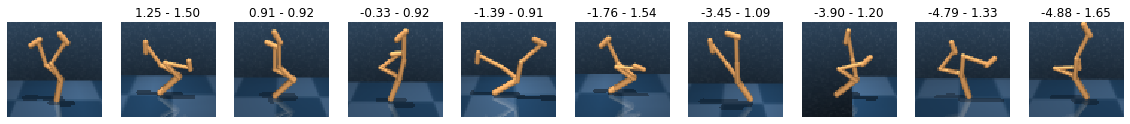

In [344]:
i = np.random.randint(env.num_goals)
i = 10
show_kNN(env, model, memory, env.goals['vec_obs'][i],env.goals['state'][i], k=9)

In [61]:
env.set_goals(memory.get_goals())
fig = env.plot_goals()

AttributeError: 'Environment' object has no attribute 'set_goals'

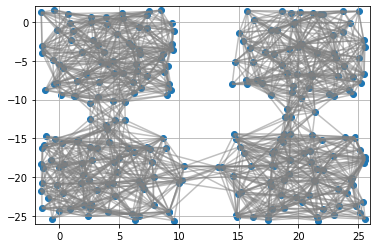

In [13]:
fig = env.plot_graph(memory)

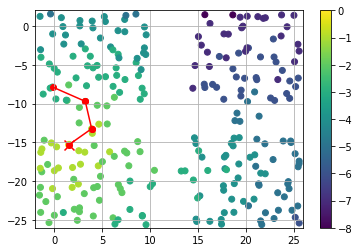

In [14]:
fig = env.plot_graph_dist(memory)

## Compute NN

In [285]:
model.to(device)
NN = compute_NN(expl_buffer, model, memory, device)

computing NN:  53%|█████▎    | 5279/10001 [23:36<21:20,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

computing NN: 100%|██████████| 10001/10001 [44:48<00:00,  3.72it/s]


## Save

In [286]:
exp_name = 'walker_thresh2-velo'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory, NN)

Saving rnet objects to  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2-velo


In [20]:
avg_distance = 0

for i in tqdm(range(expl_buffer.states.shape[0])):
    for j in range(expl_buffer.states.shape[1]):
        NN_state = memory.states[NN[i, j]]
        avg_distance += np.linalg.norm(NN_state[:2] - expl_buffer.states[i, j, :2])
        
avg_distance /= (expl_buffer.states.shape[0] * expl_buffer.states.shape[1])
print(f"Average distance from state to its NN: {avg_distance:.2f}")

100%|██████████| 10000/10000 [01:06<00:00, 150.26it/s]

Average distance from state to its NN: 1.42


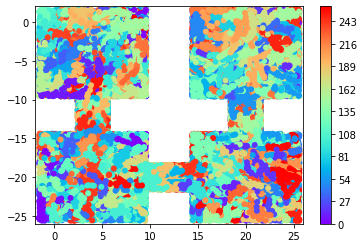

In [27]:
N = 100


traj = expl_buffer.states[:N].reshape((-1, expl_buffer.states.shape[-1]))
flat_NN = NN[:N].flatten()
classes = np.unique(flat_NN)
np.random.shuffle(classes)
c = [np.where(flat_NN[j] == classes)[0][0] for j in range(len(traj))]

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, len(classes), 1), cmap.N)

sc = plt.scatter(traj[:, 0], traj[:, 1], c=c, cmap=cmap, norm=norm, edgecolor='none')
plt.colorbar(sc)
plt.xlim(env.xlim)
plt.ylim(env.ylim)
plt.show()